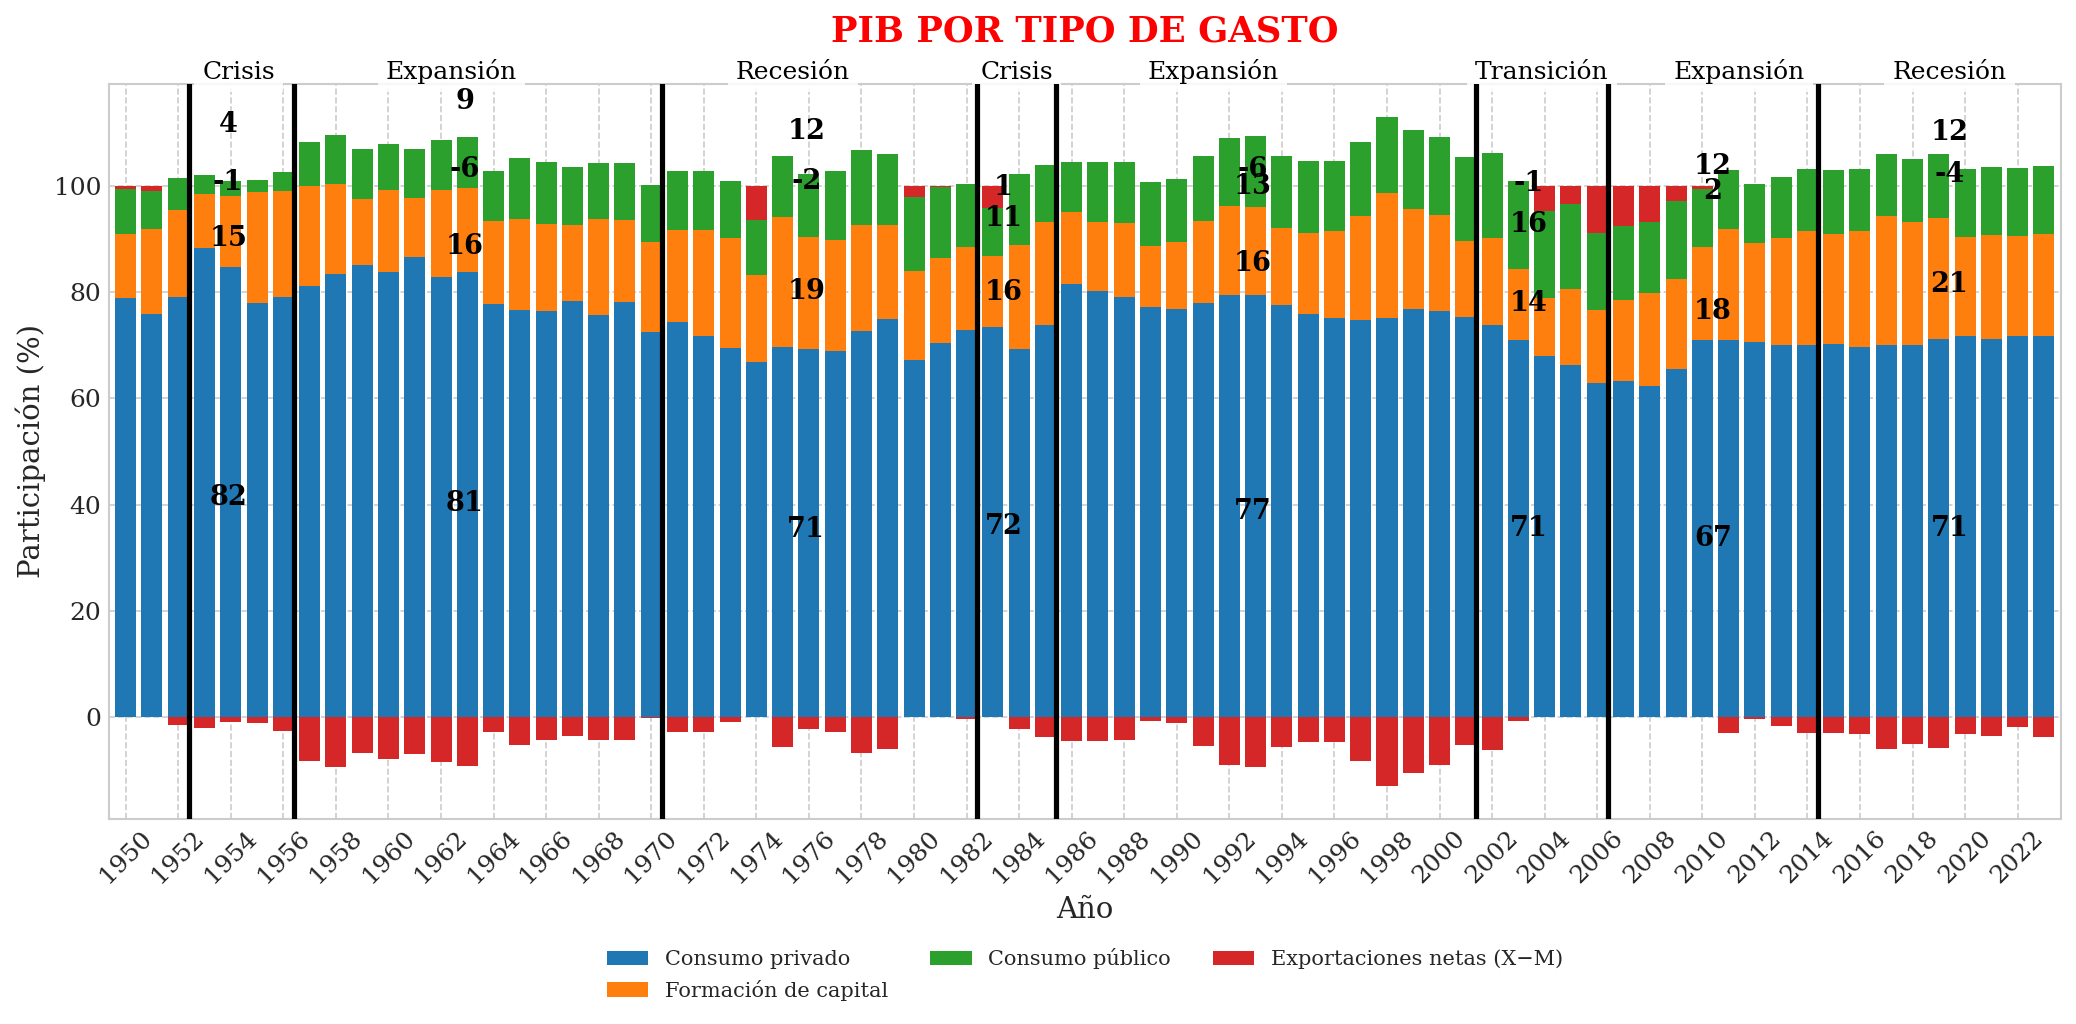

Imagen guardada en: ../../../../assets/tesis/serie_completa/pib/participacion_pib_gasto.png


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os
import numpy as np
from func_auxiliares.config import *
from func_auxiliares.graficos_utils import *


OUTPUT_DIR = "../../../../assets/tesis/serie_completa/pib"
os.makedirs(OUTPUT_DIR, exist_ok=True)

set_style()
# ── 2. Carga de datos ───────────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = pd.read_sql_query("SELECT * FROM PIB_Real_Gasto", conn)

df.set_index("año", inplace=True)
cycles_adj=adjust_cycles(df, CYCLES)

df["exportaciones_netas"] = (
    df["exportacion_bienes_servicios"] - df["importacion_bienes"]
)

# ── 3. Selección de cols_cols_cols_componentes y cálculo de participaciones (%) ───────────
componentes = [
    ("consumo_privado",     "Consumo privado"),
    ("formacion_capital",   "Formación de capital"),
    ("consumo_publico",     "Consumo público"),
    ("exportaciones_netas", "Exportaciones netas (X−M)"),
]
cols = [c for c, _ in componentes]

#offset
# Extraer sólo esas columnas
comp = df[cols]

# Convertir a porcentaje del PIB real base 1990
pct = df[cols].div(df["pib_real_base_1990"], axis=0).multiply(100)

# Cálculo de estadísticas por ciclo
cycle_stats = {
    name: pct.loc[sl, cols].mean().to_dict()
    for name, sl in cycles_adj.items()
}

#offsets
hitos_offset = {
    1952: (0, 1),
    1956: (0, 1),
    1970: (0, 1),
    1982: (0, 1),
    1985: (0, 1),
    2001: (0, 1),
    2006: (0, 1),
    2014: (0, 1)
}
hitos_text_x = {
    1952: 1.9,
    1956: 6,
    1970: 5,
    1982: 1.5,
    1985: 6,
    2001: 2.5,
    2006: 5,
    2014: 5
}


# Mapeo de colores acorde a tus otras gráficas
component_colors = [
    "#1f77b4",  # gastos_consumo
    "#ff7f0e",  # formacion_capital
    "#2ca02c",  # exportacion_bienes_servicios
    "#d62728",  # importacion_bienes
    "#9467bd",  # consumo_privado
    "#8c564b",  # consumo_publico
]

fig, ax = plot_stacked_bar(
    pct, 
    series=componentes,
    title="PIB POR TIPO DE GASTO",
    legend_ncol=3
)


MEAN_OFFSETS_BY_NAME = {
    "Crisis 52-55":      {'consumo_publico': (0.0, 12.0)},
    "Expansión 56-69":   {'consumo_publico': (0.0, 14.5)},
    "Recesión 70-81":    {'consumo_publico': (0.0, 14.5)},
    "Crisis 82-85":      {'consumo_publico': (0.0, 12.0)},
    "Expansión 86-99":   {'consumo_publico': (0.0, 15.0)},
    "Crisis 00-05":      {'consumo_publico': (0.0, 12.0)},
    "Expansión 06-14": {'consumo_publico': (0.0, 12.0)},
    "Recesión 15-23":    {'consumo_publico': (0.0, 12.0)},
}
# 2️⃣  Componentes cuyos promedios NO quieres anotar
SKIP_MEANS_BY_NAME = {
    "Crisis 52-55":      {'energia'},
    "Expansión 56-69":   {'energia'},
    "Recesión 70-81":    {'energia'},
    "Crisis 82-84":      {'energia'},
    "Expansión 85-00":   {'energia'},
    "Transicion 01-05":      {'energia'},
    "Expansión 06-14": {'energia'},
    "Recesión 15-23":    {'energia'},
}


add_hitos_barras(
    ax, df.index, hitos_v, hitos_offset, hitos_text_x
)
add_cycle_means_barras(
    ax,
    index=list(df.index),          # secuencia de años
    cycle_slices=cycles_adj,       # nombre → slice
    cycle_stats=cycle_stats,       # nombre → {col: media}
    cols=cols,                     # orden de apilado
    offsets=MEAN_OFFSETS_BY_NAME,  # opcional
    skip=SKIP_MEANS_BY_NAME        # opcional
)
# ── 6. Guardar y mostrar ───────────────────────────────────────────────────
plt.tight_layout()
out_path = os.path.join(OUTPUT_DIR, "participacion_pib_gasto.png")
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Imagen guardada en: {out_path}")

In [5]:
pct

,consumo_privado,formacion_capital,consumo_publico,exportaciones_netas
año,,,,
1950,78.913045,11.956526,8.478255,0.652173
1951,75.753772,16.080395,7.160803,1.005013
1952,79.050275,16.387334,5.959031,-1.396640
1953,88.237050,10.214413,3.603329,-2.054792
1954,84.680982,13.369886,2.878031,-0.928881
...,...,...,...,...
2019,71.055703,22.777324,12.043068,-5.876095
2020,71.742560,18.584554,12.831489,-3.158604
2021,71.219028,19.537612,12.744804,-3.501446


✓ Todas las filas de pct suman exactamente 100 %


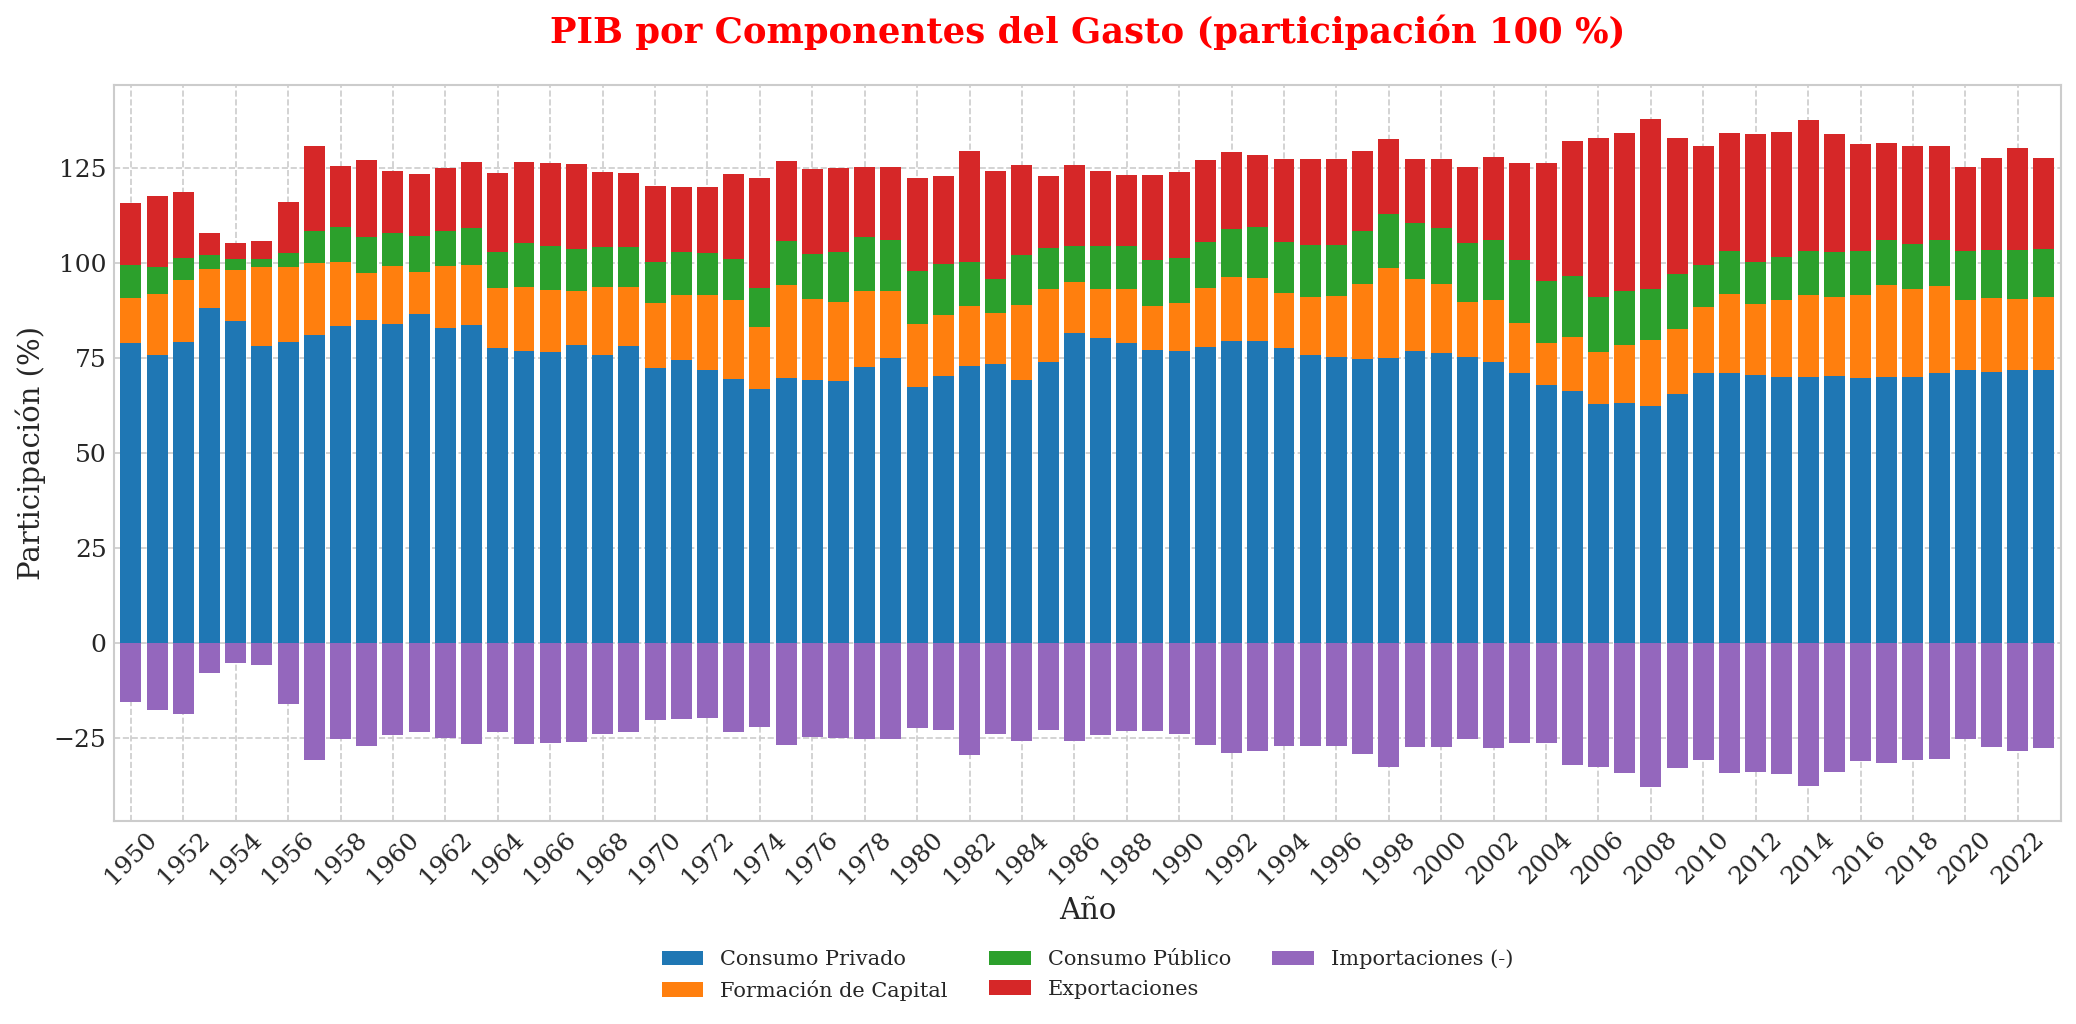

In [14]:
# ── Selección estricta de los 5 componentes del gasto ────────────────
cols_gasto = {
    "consumo_privado":  "C",   # Consumo privado
    "formacion_capital": "I",  # Inversión
    "consumo_publico":  "G",   # Gasto público
    "exportacion_bienes_servicios": "X",
    "importacion_bienes":       "M"
}

gasto = df[list(cols_gasto)].copy()

# Suma algebraica (X – M) y check contra PIB
pib_calc = (
    gasto["consumo_privado"]
  + gasto["formacion_capital"]
  + gasto["consumo_publico"]
  + gasto["exportacion_bienes_servicios"]
  - gasto["importacion_bienes"]
)

df["pib_calc"] = pib_calc
df["diff_abs"] = (df["pib_calc"] - df["pib_real_base_1990"]).abs()
# Porcentaje de cada componente sobre el PIB real
pct = gasto.div(df["pib_real_base_1990"], axis=0) * 100
pct["importacion_bienes"] *= -1   # M → signo negativo

# Comprobación rápida
check = pct.sum(axis=1).round(4)

print("✓ Todas las filas de pct suman exactamente 100 %")
# Orden, etiquetas y colores coherentes
series_100 = [
    ("consumo_privado",  "Consumo Privado"),
    ("formacion_capital","Formación de Capital"),
    ("consumo_publico",  "Consumo Público"),
    ("exportacion_bienes_servicios", "Exportaciones"),
    ("importacion_bienes","Importaciones (-)"),
]

component_colors_100 = [
    "#1f77b4",  # Consumo privado
    "#ff7f0e",  # Inversión
    "#9467bd",  # Gasto público
    "#2ca02c",  # Exportaciones
    "#d62728",  # Importaciones negativas
]

fig, ax = plot_stacked_bar(
    pct,                    # dataframe en %
    series=series_100,      # solo los 5 componentes
    title="PIB por Componentes del Gasto (participación 100 %)",
    legend_ncol=3,
)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pib_gasto_100pct.png"), dpi=300)
plt.show()



In [7]:
# ── Selección estricta de los 5 componentes del gasto ────────────────
cols_gasto = {
    "consumo_privado":  "C",   # Consumo privado
    "formacion_capital": "I",  # Inversión
    "consumo_publico":  "G",   # Gasto público
    "exportacion_bienes_servicios": "X",
    "importacion_bienes":       "M"
}

gasto = pct[list(cols_gasto)].copy()

# Suma algebraica (X – M) y check contra PIB
pib_calc = (
    gasto["consumo_privado"]
  + gasto["formacion_capital"]
  + gasto["consumo_publico"]
  + gasto["exportacion_bienes_servicios"]
  - gasto["importacion_bienes"]
)
df["pib_calc"] = pib_calc
df.head(30)

,gastos_consumo,formacion_capital,exportacion_bienes_servicios,importacion_bienes,pib_real_base_1990,consumo_privado,consumo_publico,pib_calc
año,,,,,,,,
1950,4925441.0,673879.0,918926.0,882169.0,5636077.0,4447600.0,477841.0,100.000000
1951,5013419.0,972299.0,1124221.0,1063453.0,6046487.0,4580442.0,432977.0,99.999983
1952,5336029.0,1028632.0,1081233.0,1168900.0,6276994.0,4961981.0,374048.0,100.000000
1953,5194536.0,577732.0,331817.0,448037.0,5656047.0,4990729.0,203806.0,100.000000
1954,5064556.0,773336.0,251907.0,305635.0,5784163.0,4898086.0,166470.0,100.000017
1955,4847385.0,1260661.0,290708.0,352098.0,6046657.0,4716685.0,130700.0,99.999983
1956,4720095.0,1133432.0,761929.0,911682.0,5703773.0,4512950.0,207144.0,100.000000
1957,4930016.0,1040487.0,1241914.0,1697686.0,5514731.0,4467908.0,462107.0,99.999982
1958,5227729.0,948817.0,901796.0,1434141.0,5644201.0,4707139.0,520590.0,100.000000
